# Importing Libraries

In [1]:
from datetime import date
from os.path import join,exists,expanduser
from os import listdir,mkdir
from torch import (from_numpy,device, set_float32_matmul_precision)
from torch.cuda import is_available
from torch.nn import Sequential, Sigmoid
from torch.optim import Adam
from torchvision.datasets import MNIST
from monai.transforms import (Compose,RandRotate90d,RandFlipd)
from monai.data import DataLoader,Dataset
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningModule, Trainer
from sklearn.model_selection import train_test_split
from torchmetrics.classification import (BinaryF1Score, BinaryPrecision,
                                         BinaryAccuracy)
from process_data import MNIST_DATA, TENSOR_DATA
from warnings import filterwarnings
from unet import Unet

import matplotlib.pyplot as plt
import numpy as np

2023-04-27 09:47:02,037 - Created a temporary directory at /tmp/tmp1vebgws3
2023-04-27 09:47:02,038 - Writing /tmp/tmp1vebgws3/_remote_module_non_scriptable.py


In [2]:
set_float32_matmul_precision('high')
filterwarnings('ignore')

## Downloading data

If is your first time runnig this code, set **download = True**, but if is not, you can set **download = False**

In [3]:
#Add the directory for save the dataset
directory = ''
mnist_trainset = MNIST(root=directory, train=True,
                                download=False, transform=None)
mnist_testset = MNIST(root=directory, train=False,
                               download=False, transform=None)

## Loading the Dataset

In [4]:
X_true,Y_true = MNIST_DATA(mnist_trainset,mnist_testset)

========= Converting list to numpy array =========
Dataset Shape: (70000, 28, 28, 1)
Dataset Shape: (70000,)

========= Transforming Data into Labels =========
Discarded Labels: 630000
Discarded Images: 630000
Useful Labels: 70000
Discarded Images: 630000
Useful Images: 70000

========= Transforming Data into Numpy array =========
Input Shape: (70000, 28, 28, 1)
Labels Shape:(70000, 28, 28, 1)



## Plotting Data

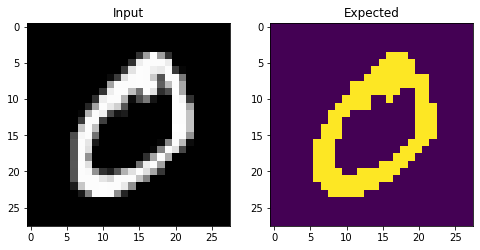

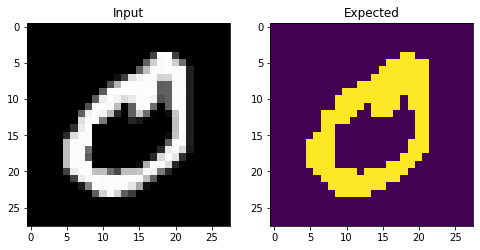

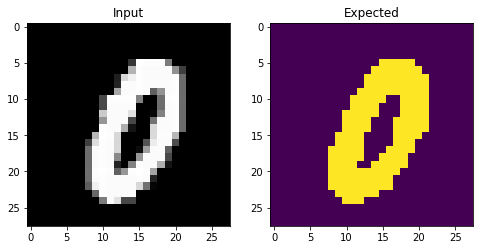

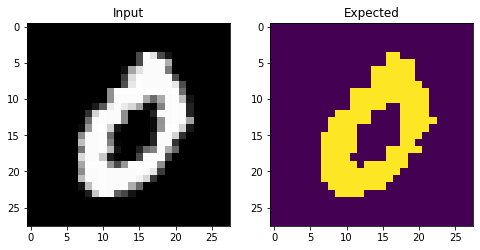

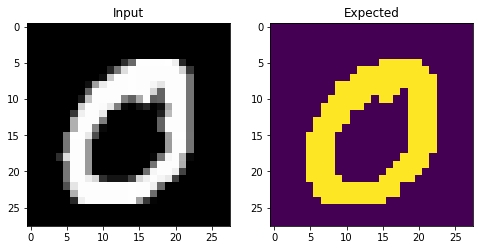

In [5]:
# n_img_plot = choose how much images do you want to plot
n_img_plot = 5
for i in range(0,n_img_plot):
    plt.figure(figsize=(8,10))
    plt.subplot(121)
    plt.imshow(X_true[i,:,:,0], cmap='gray')
    plt.title('Input')
    plt.subplot(122)
    plt.imshow(Y_true[i,:,:,0])
    plt.title('Expected')

## Randomizing Data

In [6]:
idx = np.random.permutation(X_true.shape[0])
X_true = X_true[idx]
Y_true = Y_true[idx]

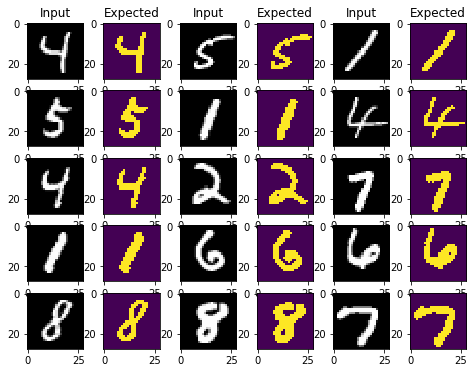

In [7]:
i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 2*ncols, figsize=(8, 6))
for j in range(0, axes.shape[1], 2):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0], cmap='gray')
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()

## Separating the Data

In [8]:
images_torch_pred = X_true[69950:]
print(f'Dataset Train and Valid Image{images_torch_pred.shape}')
labels_torch_pred = Y_true[69950:]
print(f'Dataset Train and Valid Label{labels_torch_pred.shape}')

X_true = X_true[0:69949]
Y_true = Y_true[0:69949]

Dataset Train and Valid Image(50, 28, 28, 1)
Dataset Train and Valid Label(50, 28, 28, 1)


In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_true,
                                                    Y_true,
                                                    test_size=1/4)
print(f'Train Dataset: {x_train.shape}')
print(f'Test Dataset:  {x_test.shape}')

Train Dataset: (52461, 28, 28, 1)
Test Dataset:  (17488, 28, 28, 1)


### Transforming the Data to tensor

In [10]:
x_train, x_test, y_train, y_test, images_torch_pred, labels_torch_pred = TENSOR_DATA(x_train, x_test, y_train,
                                                                                     y_test, images_torch_pred, labels_torch_pred)

Type of the data. Must be float32: float32
X_train shape: torch.Size([52461, 1, 28, 28]) and format: <class 'torch.Tensor'>
Y_train shape: torch.Size([52461, 1, 28, 28]) and format: <class 'torch.Tensor'>

X_test shape: torch.Size([17488, 1, 28, 28]) and format: <class 'torch.Tensor'>
Y_test shape: torch.Size([17488, 1, 28, 28]) and format: <class 'torch.Tensor'>

Pred images shape: torch.Size([50, 1, 28, 28]) and format: <class 'torch.Tensor'>
Pred labels shape: torch.Size([50, 1, 28, 28]) and format: <class 'torch.Tensor'>


### Putting the data into dictionary

In [11]:
train_files = [{'x':img, 'y':lbl} for img,lbl in zip(x_train,y_train)]
val_files = [{'x':img, 'y':lbl} for img,lbl in zip(x_test,y_test)]

## Selecting augmentation transforms

In [12]:
#setting augmentation transformations for training
train_transforms = Compose([RandRotate90d(keys = ['x','y'],prob=0.5),
                        RandFlipd(keys = ['x','y'],prob=0.6,spatial_axis = 0)])

#setting augmentation transformations for validation
val_transforms = Compose([RandRotate90d(keys = ['x','y'],prob=0.5),
                           RandFlipd(keys = ['x','y'],prob=0.4,spatial_axis = 0)])

## Loading DataLoader

If you want to set the transforms above or any other else transformation, set **transfrom = train_transforms**

In [13]:
#loading dataset on dataloaders
train_ds = Dataset(data=train_files, transform = None)
train_loader = DataLoader(train_ds,batch_size=15000, shuffle=True,
                          num_workers = 16, pin_memory=False)

val_ds = Dataset(data=val_files, transform = None)
val_loader = DataLoader(val_ds,batch_size=15000, shuffle=False,
                        num_workers = 16,pin_memory=False)

## Selecting Gpu or Cpu

In [14]:
#Selecting CPU or GPU for
device = device('cuda' if is_available() else 'cpu')
device
# If you have a gpu, uncomment and select the device on line below
# device = device('cuda:0')

device(type='cuda')

## Creating Directory to Save Files

In [15]:
model_number = 0
today = date.today()
dirpath = expanduser('~/unet_modelos_treinados/mnist')

if not exists(join(dirpath,f'Model_{int(model_number)}_Date_{today}')):
        mkdir(join(dirpath,f'Model_{int(model_number)}_Date_{today}'))
else:
    while exists(join(dirpath,f'Model_{int(model_number)}_Date_{today}')) is True:
        model_number += 1
        if not exists (join(dirpath,f'Model_{int(model_number)}_Date_{today}')):
            mkdir(join(dirpath,f'Model_{int(model_number)}_Date_{today}'))
            break
            
model_dir = join(dirpath,f'Model_{int(model_number)}_Date_{today}')
print('The directory was created with sucess!!')
print(f'Directory:{model_dir}')

The directory was created with sucess!!
Directory:/home/romulo/unet_modelos_treinados/mnist/Model_0_Date_2023-04-27


## Unet training

In [16]:
model = Unet()
early_stopping = EarlyStopping(monitor='Val_loss',
                               min_delta = 0.0,
                               patience = 5, verbose = True,
                              check_on_train_epoch_end = True)
model_checkpoint =  ModelCheckpoint(save_top_k = 1,
                                    monitor = 'Val_loss',
                                    mode='min',
                                    dirpath = model_dir,
                                    filename ='model_avg-{epoch}-{Val_loss:.3f}',
                                   save_on_train_epoch_end = True)
logger = TensorBoardLogger(save_dir = model_dir,
                              name=f'model_logs')
trainer = Trainer(max_epochs=20000, 
                    accelerator='gpu', devices=1, #[0,1] or -1
                    callbacks = [early_stopping, model_checkpoint],
                    log_every_n_steps=34,
                    logger=logger)
trainer.fit(model,train_loader,val_loader)

2023-04-27 09:49:28,996 - GPU available: True (cuda), used: True
2023-04-27 09:49:28,997 - TPU available: False, using: 0 TPU cores
2023-04-27 09:49:28,998 - IPU available: False, using: 0 IPUs
2023-04-27 09:49:28,998 - HPU available: False, using: 0 HPUs
2023-04-27 09:49:29,173 - Missing logger folder: /home/romulo/unet_modelos_treinados/mnist/Model_0_Date_2023-04-27/model_logs
2023-04-27 09:49:30,376 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2023-04-27 09:49:30,379 - 
  | Name      | Type                     | Params
-------------------------------------------------------
0 | model     | Sequential               | 73.0 K
1 | loss      | GeneralizedDiceFocalLoss | 0     
2 | train_acc | BinaryAccuracy           | 0     
3 | valid_acc | BinaryAccuracy           | 0     
4 | f1_score  | BinaryF1Score            | 0     
5 | prec      | BinaryPrecision          | 0     
-------------------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
7

2023-04-27 09:49:37,630 - Metric Val_loss improved. New best score: 0.969


2023-04-27 09:49:41,268 - Metric Val_loss improved by 0.078 >= min_delta = 0.0. New best score: 0.890


2023-04-27 09:49:44,917 - Metric Val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.840


2023-04-27 09:49:48,641 - Metric Val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.802


2023-04-27 09:49:52,281 - Metric Val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.768


2023-04-27 09:49:55,876 - Metric Val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.735


2023-04-27 09:49:59,514 - Metric Val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.703


2023-04-27 09:50:03,227 - Metric Val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.671


2023-04-27 09:50:06,846 - Metric Val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.639


2023-04-27 09:50:10,494 - Metric Val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.607


2023-04-27 09:50:14,241 - Metric Val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.576


2023-04-27 09:50:17,915 - Metric Val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.546


2023-04-27 09:50:21,566 - Metric Val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.517


2023-04-27 09:50:25,203 - Metric Val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.489


2023-04-27 09:50:28,857 - Metric Val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.463


2023-04-27 09:50:32,519 - Metric Val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.438


2023-04-27 09:50:36,149 - Metric Val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.415


2023-04-27 09:50:39,774 - Metric Val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.393


2023-04-27 09:50:43,414 - Metric Val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.372


2023-04-27 09:50:47,138 - Metric Val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.354


2023-04-27 09:50:50,790 - Metric Val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.337


2023-04-27 09:50:54,524 - Metric Val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.321


2023-04-27 09:50:58,213 - Metric Val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.307


2023-04-27 09:51:01,860 - Metric Val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.295


2023-04-27 09:51:05,670 - Metric Val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.283


2023-04-27 09:51:09,262 - Metric Val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.273


2023-04-27 09:51:12,972 - Metric Val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.263


2023-04-27 09:51:16,597 - Metric Val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.256


2023-04-27 09:51:20,204 - Metric Val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.249


2023-04-27 09:51:23,935 - Metric Val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.242


2023-04-27 09:51:27,547 - Metric Val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.238


2023-04-27 09:51:31,225 - Metric Val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.232


2023-04-27 09:51:34,924 - Metric Val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.227


2023-04-27 09:51:38,590 - Metric Val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.224


2023-04-27 09:51:42,313 - Metric Val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.221


2023-04-27 09:51:45,989 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.220


2023-04-27 09:51:49,709 - Metric Val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.214


2023-04-27 09:51:53,345 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.214


2023-04-27 09:51:57,125 - Metric Val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.210


2023-04-27 09:52:00,764 - Metric Val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.207


2023-04-27 09:52:04,423 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.206


2023-04-27 09:52:08,124 - Metric Val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.204


2023-04-27 09:52:11,729 - Metric Val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.203


2023-04-27 09:52:15,402 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.201


2023-04-27 09:52:19,061 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.200


2023-04-27 09:52:22,796 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.199


2023-04-27 09:52:26,426 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.197


2023-04-27 09:52:30,104 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.196


2023-04-27 09:52:33,794 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.195


2023-04-27 09:52:37,512 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.195


2023-04-27 09:52:41,151 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.193


2023-04-27 09:52:44,800 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.192


2023-04-27 09:52:48,450 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.192


2023-04-27 09:52:52,150 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.191


2023-04-27 09:52:55,794 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.190


2023-04-27 09:52:59,414 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.190


2023-04-27 09:53:02,964 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.189


2023-04-27 09:53:10,067 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.188


2023-04-27 09:53:13,552 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.187


2023-04-27 09:53:17,049 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.187


2023-04-27 09:53:20,568 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.186


2023-04-27 09:53:27,618 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.185


2023-04-27 09:53:31,113 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.185


2023-04-27 09:53:34,641 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.184


2023-04-27 09:53:38,195 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.184


2023-04-27 09:53:41,708 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.184


2023-04-27 09:53:45,201 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.183


2023-04-27 09:53:48,729 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.183


2023-04-27 09:53:52,248 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.182


2023-04-27 09:53:55,736 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.182


2023-04-27 09:54:02,870 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.181


2023-04-27 09:54:06,448 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.181


2023-04-27 09:54:09,989 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.181


2023-04-27 09:54:13,462 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.180


2023-04-27 09:54:16,983 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.180


2023-04-27 09:54:28,033 - Metric Val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.179


2023-04-27 09:54:31,687 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.179


2023-04-27 09:54:35,435 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.179


2023-04-27 09:54:39,097 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.178


2023-04-27 09:54:42,877 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.178


2023-04-27 09:54:46,577 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.178


2023-04-27 09:54:50,205 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.177


2023-04-27 09:54:53,919 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.177


2023-04-27 09:55:04,903 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.177


2023-04-27 09:55:08,610 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.177


2023-04-27 09:55:12,274 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.176


2023-04-27 09:55:19,649 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.176


2023-04-27 09:55:23,337 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.176


2023-04-27 09:55:26,994 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.175


2023-04-27 09:55:30,684 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.175


2023-04-27 09:55:34,313 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.175


2023-04-27 09:55:38,026 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.175


2023-04-27 09:55:41,710 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.175


2023-04-27 09:55:45,384 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.174


2023-04-27 09:55:48,982 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.174


2023-04-27 09:55:56,333 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.174


2023-04-27 09:56:00,116 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.174


2023-04-27 09:56:03,858 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.174


2023-04-27 09:56:07,530 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.173


2023-04-27 09:56:11,226 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.173


2023-04-27 09:56:18,580 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.173


2023-04-27 09:56:22,263 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.173


2023-04-27 09:56:25,980 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.173


2023-04-27 09:56:33,321 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.173


2023-04-27 09:56:37,016 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.172


2023-04-27 09:56:40,697 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.172


2023-04-27 09:56:44,395 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.172


2023-04-27 09:56:48,095 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.172


2023-04-27 09:56:55,397 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.172


2023-04-27 09:57:06,466 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.171


2023-04-27 09:57:10,179 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.171


2023-04-27 09:57:13,828 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.171


2023-04-27 09:57:17,555 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.171


2023-04-27 09:57:24,839 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170


2023-04-27 09:57:32,231 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170


2023-04-27 09:57:39,709 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170


2023-04-27 09:57:50,786 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170


2023-04-27 09:57:54,446 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170


2023-04-27 09:57:58,116 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170


2023-04-27 09:58:01,719 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170


2023-04-27 09:58:05,405 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:09,013 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:12,716 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:16,372 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:27,367 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:34,755 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:38,464 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:45,803 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.169


2023-04-27 09:58:49,597 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:58:57,027 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:59:00,721 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:59:08,226 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:59:12,000 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:59:23,076 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:59:41,650 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:59:48,975 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.168


2023-04-27 09:59:56,507 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.167


2023-04-27 10:00:07,635 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.167


2023-04-27 10:00:11,263 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.167


2023-04-27 10:00:18,756 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.167


2023-04-27 10:00:22,457 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.167


2023-04-27 10:00:30,142 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.167


2023-04-27 10:00:37,477 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.167


2023-04-27 10:00:55,967 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.166


2023-04-27 10:01:07,115 - Metric Val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.166


2023-04-27 10:01:25,878 - Monitored metric Val_loss did not improve in the last 5 records. Best score: 0.166. Signaling Trainer to stop.



## Predict Step

In [17]:
#creating a dataloader for prediction
pred_ds = Dataset(data=images_torch_pred, transform = None)
pred_loader = DataLoader(pred_ds,batch_size=50, shuffle=False,
                          num_workers = 12, pin_memory=False)

## Saved Models

In [18]:
# Recommended to choose by index the model with 
# the highest value of epoch or the lowest value of loss
# Usually, the best model have both
models = listdir(model_dir)
for i in range(len(models)):
    print(f'Index:{i}, Model: {models[i]}')

Index:0, Model: model_avg-epoch=188-Val_loss=0.166.ckpt
Index:1, Model: model_logs


### Loading the model

The default behaviour of the predict_step is to run foward method

In [19]:
#Choose the index
index = 0

#predicting with the model
modelo = model.load_from_checkpoint(join(model_dir,models[index]))
trainer_pred = Trainer(accelerator='gpu', devices=1)
predict_step = trainer_pred.predict(modelo, pred_loader)

2023-04-27 10:01:49,027 - GPU available: True (cuda), used: True
2023-04-27 10:01:49,028 - TPU available: False, using: 0 TPU cores
2023-04-27 10:01:49,028 - IPU available: False, using: 0 IPUs
2023-04-27 10:01:49,029 - HPU available: False, using: 0 HPUs
2023-04-27 10:01:49,031 - Missing logger folder: /home/romulo/MNIST_UNET/MNIST_UNET/lightning_logs
2023-04-27 10:01:49,040 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


## Plotting the Prediction

In [20]:
#joining all prediction images on a unique list and transform on tensor
total_predictions = []

for pred_loader in predict_step:
    for pred_tns in pred_loader:
        total_predictions.append(pred_tns)
        
print(f'Predictions Size: {len(total_predictions)}')

Predictions Size: 50


In [21]:
#removing chanel from images, labels and preds for plotting
images_pred = [(lambda k: k[0,:,:])(k) for k in images_torch_pred]
labels_pred = [(lambda k: k[0,:,:])(k) for k in labels_torch_pred]
total_pred = [(lambda k: k[0,:,:])(k) for k in total_predictions]

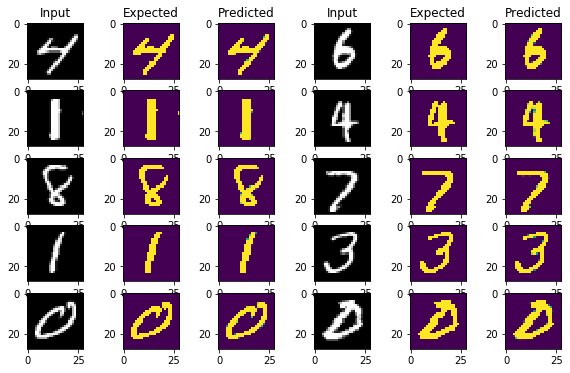

In [22]:
i0 = 1
ncols = 2
fig, axes = plt.subplots(5,ncols*3, figsize=(10, 6))
for l in range(0, axes.shape[1], 3):
    axes[0, l+0].set_title('Input')
    axes[0, l+1].set_title('Expected')
    axes[0, l+2].set_title('Predicted')
    for m in range(axes.shape[0]):
        axes[m, l+0].imshow(images_pred[ncols*l+i0+m], cmap='gray')
        axes[m, l+1].imshow(labels_pred[ncols*l+i0+m], vmin=0, vmax=1)
        axes[m, l+2].imshow(total_pred[ncols*l+i0+m], vmin=0, vmax=1)
plt.show()